# Lab Assignment Four: Multi-Layer Perceptron 

Team Members: Nicholas Benso, Benjamin Kuo

Dataset Selection: US Census data

Box Link: https://www.dropbox.com/s/bf7i7qjftk7cmzq/acs2017_census_tract_data.csv?dl=0Links

Kaggle Link: https://www.kaggle.com/muonneutrino/us-census-demographic-data/dataLinks

The classification task you will be performing is to predict, for each county, what the child poverty rate will be. You will need to convert this from regression to four levels of classification by quantizing the variable of interest. 

## Load, Split, and Balance (1.5 points total)
[.5 points] (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric. (2) Remove any observations that having missing data. (3) Encode any string data as integers for now. (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable. 
The next two requirements will need to be completed together as they might depend on one another:

[.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

[.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is NO NEED to split the data multiple times for this lab.
Note: You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab. 


In [8]:
import os
current_directory = os.getcwd()
print(current_directory) 

C:\Users\nicho\ML_Lab4\ML_lab4


In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import sys

df = pd.read_csv(r"C:\Users\nicho\ML_Lab4/ML_lab4/acs2017_census_tract_data.csv") # read in the csv file

df.info()
df.describe()


df.dropna(subset='ChildPoverty',inplace=True)
for col in df:
    if df[col].count() < df.shape[0]:
        del df[col]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

In [274]:
df['State'].replace(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'],
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51], inplace=True)
del df['County']
del df['TractId']
df['ChildPoverty'].quantile([.25, .5, .75])

0.25     6.2
0.50    16.3
0.75    31.6
Name: ChildPoverty, dtype: float64

In [275]:

for index, row in df.iterrows():
    if row["ChildPoverty"] < 6.2:
        df.at[index, 'ChildPoverty'] = 0
    elif row["ChildPoverty"] >= 6.2 and row["ChildPoverty"] < 16.3:
        df.at[index, 'ChildPoverty'] = 1
    elif row["ChildPoverty"] >= 16.3 and row["ChildPoverty"] < 31.6:
        df.at[index, 'ChildPoverty'] = 2
    elif row["ChildPoverty"] >= 31.6:
        df.at[index, 'ChildPoverty'] = 3
    int(row["ChildPoverty"])


In [276]:
tmpdf = pd.get_dummies(df['ChildPoverty'],prefix='quartile')
tmpdf.head()

,quartile_0.0,quartile_1.0,quartile_2.0,quartile_3.0
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,1,0,0,0
4,0,0,1,0


In [277]:
from sklearn.model_selection import ShuffleSplit, train_test_split
# we want to predict the X and y data as follows:
if 'ChildPoverty' in df:
    y = df['ChildPoverty'].to_numpy() # get the labels we want
    if 'ChildPoverty' in df:    
        del df['ChildPoverty']
    
    df.info()
    
    #norm_features = ['State', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Poverty', 'Employed']
    #df[norm_features] = (df[norm_features]-df[norm_features].mean()) / df[norm_features].std()
    X = df.to_numpy() # use everything else to predict!
    df = pd.concat((df,tmpdf),axis=1)

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72891 entries, 0 to 74000
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             72891 non-null  int64  
 1   TotalPop          72891 non-null  int64  
 2   Men               72891 non-null  int64  
 3   Women             72891 non-null  int64  
 4   Hispanic          72891 non-null  float64
 5   White             72891 non-null  float64
 6   Black             72891 non-null  float64
 7   Native            72891 non-null  float64
 8   Asian             72891 non-null  float64
 9   Pacific           72891 non-null  float64
 10  VotingAgeCitizen  72891 non-null  int64  
 11  Poverty           72891 non-null  float64
 12  Employed          72891 non-null  int64  
dtypes: float64(7), int64(6)
memory usage: 9.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 72891 entries, 0 to 74000
Data columns (total 17 columns):
 #   Column            Non-

## Pre-processing and Initial Modeling (2.5 points total)
You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

[.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

[.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

[.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

[1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  
Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.


In [188]:
from sklearn.metrics import accuracy_score

class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

'''
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2


# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
class TLPVectorizedMiniBatch(TwoLayerPerceptronVectorized):
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):

            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            
        return self

from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_l_bfgs_b
class TLPVectorizedBFGS(TwoLayerPerceptronVectorized):
    
    def __init__(self, gtol=1e-5, **kwds):        
        # need to add to the original initializer 
        self.gtol = gtol
        
        # but keep other keywords
        super().__init__(**kwds)
        
    @staticmethod
    def _pack(in1, in2):
        return np.hstack((in1.flatten(),in2.flatten()))
    
    def _unpack(self, in_tot):
        out1 = in_tot[:self.W1.size].reshape(self.W1.shape)
        out2 = in_tot[self.W1.size:].reshape(self.W2.shape)
        return out1, out2
    
    def _calc_cost_gradient_packed(self,W,X_data,Y_enc):
        W1, W2 = self._unpack(W) 
        # feedforward all instances
        A1, Z1, A2, Z2, A3 = self._feedforward(X_data,W1,W2)
        
        cost = np.sum((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        cost = cost + L2_term
        #perform back prop to get gradients
        grad1,grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3,Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                         W1=W1, W2=W2)
        return cost, self._pack(grad1,grad2)
    
    def _cost_packed(self,W,X_data,Y_enc):
        W1, W2 = self._unpack(W)
        _, _, _, _, A3 = self._feedforward(X_data,W1,W2)
        return np.sum((Y_enc-A3)**2)
    
    def fit(self,X,y,print_progress=0):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # make initial matrices into single row vector
        W = self._pack(self.W1,self.W2)
        
        if print_progress>0:
            def callback(xd):
                callback.counter += 1
                if callback.counter%print_progress==0:
                    sys.stderr.write('\rEpoch: %d/%d (max)' % (callback.counter,callback.epochs))
                    sys.stderr.flush()

            callback.counter = 0
            callback.epochs = self.epochs
            
        else:
            callback = None
            
        # compute gradient optimum with bfgs
        W_best,_,props = fmin_l_bfgs_b(
                        x0=W,
                        func=self._calc_cost_gradient_packed,
                        maxfun=self.epochs,
                        callback=callback,
                        pgtol=self.gtol,
                        args=(X_data, Y_enc))
        
        self.W1, self.W2 = self._unpack(W_best)
        if print_progress:
            print(props)
'''
    
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
    
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

    
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

    
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    


Epoch: 1/200

CPU times: total: 3.5 s
Wall time: 7.76 s


Epoch: 1/200

CPU times: total: 3.44 s
Wall time: 7.82 s


Epoch: 20/20

CPU times: total: 3.61 s
Wall time: 8.13 s
Cross Entropy Loss :
Resubstitution acc: 0.2505316229935519
Validation acc: 0.2494684134714315
MSE Loss :
Resubstitution acc: 0.2483708327616957
Validation acc: 0.2494684134714315
MSE Loss :
Resubstitution acc: 0.24948552613527233
Validation acc: 0.2524178613073599


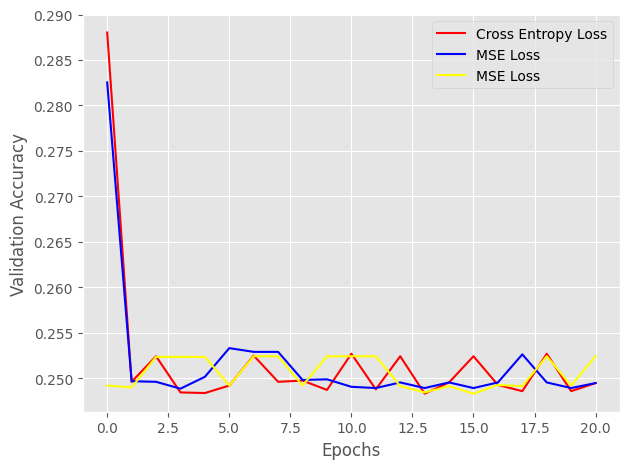

In [279]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = TLPMiniBatch(**vals)
nn_cross = TLPMiniBatchCrossEntropy(**vals)
nn_better = TLPBetterInitial(**vals)
%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")
print_result(nn_better,X_train,y_train,X_test,y_test,title="MSE Loss",color="yellow")

plt.show()

## Modeling (5 points total)
[1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

[1 points] Repeat the previous step, adding support for a fourth layer.

[1 points] Repeat the previous step, adding support for a fifth layer. 

[2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (such as AdaGrad, RMSProps, or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.